In [ ]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np

# Criar dados fictícios com relação linear entre 'Estudo' e 'Tempo_de_Sono' e 'Nota'
np.random.seed(0)
n_samples = 1000
estudo = np.random.randint(1, 11, size=n_samples)
tempo_de_sono = np.random.randint(1, 11, size=n_samples)
nota = 50 + 3 * estudo + 2 * tempo_de_sono + np.random.normal(0, 5, size=n_samples)

# Criar DataFrame
data = pd.DataFrame({'Estudo': estudo, 'Tempo_de_Sono': tempo_de_sono, 'Nota': nota})

# Exibir primeiras linhas dos dados
print(data.head())

   Estudo  Tempo_de_Sono       Nota
0       6             10  88.957254
1       1              1  59.402556
2       4             10  79.729598
3       4              1  64.429760
4       8              3  83.759733


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.models import BayesianModel

# Separe os recursos e a variável de destino
X = data[['Estudo', 'Tempo_de_Sono']]
y = data['Nota']

# Aplicar Boruta para seleção de características
boruta_selector = BorutaPy(RandomForestRegressor(), n_estimators='auto', verbose=2)
boruta_selector.fit(X.values, y.values)

# Imprimir as variáveis selecionadas pelo Boruta
selected_features = X.columns[boruta_selector.support_]
print("Variáveis selecionadas pelo Boruta:")
print(selected_features)

# Use apenas as características selecionadas pelo Boruta
X_selected = X[selected_features]

# Aplique o algoritmo HillClimbSearch para inferir a estrutura da rede Bayesiana
hc = HillClimbSearch(X_selected)
best_model = hc.estimate(scoring_method=K2Score(X_selected))

# Imprima as arestas do modelo resultante
print("\nEstrutura da Rede Bayesiana:")
print(best_model.edges())


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	0
Variáveis selecionadas pelo Boruta:
Index(['Estudo', 'Tempo_de_Sono'], dtype='object')


  0%|          | 0/1000000 [00:00<?, ?it/s]


Estrutura da Rede Bayesiana:
[]


In [ ]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def calculate_likelihood(data, structure):
    likelihood = 1.0

    for node in structure:
        if not structure[node]:
            counts = data[node].value_counts()
            probabilities = counts / len(data)  # Correção aqui
            for value in probabilities:
                likelihood *= value
        else:
            parents = structure[node]
            cpd = data.groupby(parents + [node]).size() / len(data)
            likelihood *= cpd.prod()  # Simplificação aqui

    return likelihood

def calculate_score(data, structure):
    num_nodes = len(structure)
    num_edges = sum(len(parents) for parents in structure.values()) // 2
    num_samples = len(data)

    likelihood = calculate_likelihood(data, structure)
    complexity_penalty = 0.5 * np.log(num_samples) * num_edges

    score = likelihood - complexity_penalty
    return score


def find_neighbors(node, structure):
    neighbors = []
    for target_node, parents in structure.items():
        if node in parents:
            neighbors.append(target_node)
    return neighbors

def k2_algorithm(data, max_parents):
    num_nodes = len(data.columns)
    structure = {node: [] for node in data.columns}
    total_score = 0

    for node in data.columns:
        candidate_parents = [n for n in data.columns if n != node]
        parents_added = 0

        while parents_added < max_parents:
            best_parent = None
            best_score = -np.inf

            for candidate_parent in candidate_parents:
                if candidate_parent not in structure[node] and node not in structure[candidate_parent]:
                    new_structure = {k: v[:] for k, v in structure.items()}
                    new_structure[node].append(candidate_parent)
                    score = calculate_score(data, new_structure)

                    if score > best_score:
                        best_score = score
                        best_parent = candidate_parent

            if best_parent is None:
                break

            structure[node].append(best_parent)
            parents_added += 1

            # Acumular o score total
            total_score += best_score

    print("Estrutura da Rede Aprendida:")
    for node, parents in structure.items():
        print(f"{node}: {parents}")

    return total_score

# Carregar dados do arquivo CSV
data = pd.read_csv('teste.csv')

# Executar o algoritmo K2 no conjunto de dados
total_score = k2_algorithm(data, max_parents=5)

# Imprimir o score total
print(f'Score Total: {total_score}')


Estrutura da Rede Aprendida:
age: ['spectacle-prescrip', 'astigmatism', 'tear-prod-rate', 'contact-lenses']
spectacle-prescrip: ['astigmatism', 'tear-prod-rate', 'contact-lenses']
astigmatism: ['tear-prod-rate', 'contact-lenses']
tear-prod-rate: ['contact-lenses']
contact-lenses: []
Score Total: -39.72567287208157


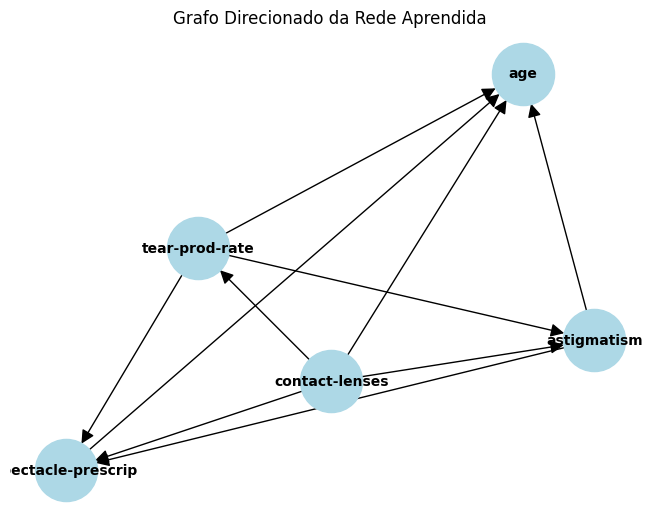

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar nós ao grafo
for node in learned_structure:
    G.add_node(node)

# Adicionar arestas ao grafo
for node, parents in learned_structure.items():
    for parent in parents:
        G.add_edge(parent, node)

# Plotar o grafo
pos = nx.spring_layout(G)  # Layout para visualização
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title('Grafo Direcionado da Rede Aprendida')
plt.show()


In [3]:
pip install matplotlib

     ---------------------------------------- 0.0/162.3 kB ? eta -:--:--
     -------------------------------------- 162.3/162.3 kB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -- ------------------------------------- 0.4/7.6 MB 12.9 MB/s eta 0:00:01
   ---- ----------------------------------- 0.9/7.6 MB 11.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.5/7.6 MB 11.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.0/7.6 MB 11.7 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.6 MB 11.7 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.6 MB 11.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.6 MB 11.7 MB/s eta 0:00:01
   --------------------- ------------------ 4.2/7.6 MB 11.6 MB/s eta 0:00:01
   ------------------------ --------------- 4.7/7.6 MB 11.6 MB/s eta 0:00:01
   --------------------------- ------------ 5.3/7.6 MB 11.6 MB/s eta 0:00:01
   -----

ARQUIVO:     age  spectacle-prescrip  astigmatism  tear-prod-rate  contact-lenses
0     2                   1            0               1               1
1     2                   1            0               0               2
2     2                   1            1               1               1
3     2                   1            1               0               0
4     2                   0            0               1               1
5     2                   0            0               0               2
6     2                   0            1               1               1
7     2                   0            1               0               0
8     0                   1            0               1               1
9     0                   1            0               0               2
10    0                   1            1               1               1
11    0                   1            1               0               0
12    0                   0            0  

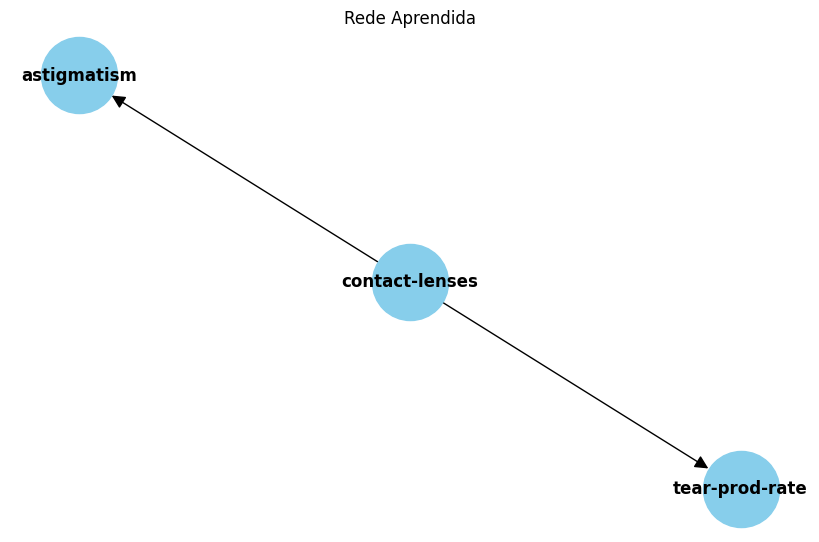

Tempo gasto: 0.16012859344482422


In [73]:
import pandas as pd
import sys
from pgmpy.estimators import K2Score
from sklearn.preprocessing import LabelEncoder
import time
import random
import networkx as nx
import matplotlib.pyplot as plt

def load_data(DATA_CSV):
    D = pd.read_csv('teste.csv')
    D = D.apply(LabelEncoder().fit_transform)

    V = D.columns
    N = len(D.index)
    V_CARD = {v: len(D[v].unique()) for v in V}


    print(f'ARQUIVO: {D}')
    print(f'VARIÁVEIS: {V}')
    print(f'NÚMERO DE AMOSTRAS: {N}')
    print(f'MAPEAMENTO DAS VARIÁVEIS COM NÚMEROS DE VALORES ÚNICOS: {V_CARD}')
    return D, V, N, V_CARD

def predecessors(x, pa, ordering):
    pred = []
    x_idx = ordering.index(x)
    for y in ordering[:x_idx]:
        if y not in pa:
            pred.append(y)
    return pred

def K2_algorithm(ordering, max_parents, D):
    k2sc = K2Score(D).local_score
    PI = {v: [] for v in V}
    total_score = 0  # Inicializar o score total

    for x in V[1:]:
        proceed = True
        old_sc = k2sc(x, PI[x])
        while proceed and len(PI[x]) < max_parents[x]:
            proceed = False
            z, new_sc = None, None
            pred = predecessors(x, PI[x], ordering)
            if pred != []:
                z, new_sc = max([(y, k2sc(x, PI[x] + [y])) for y in pred], key=lambda t: t[1])
                if new_sc > old_sc:
                    old_sc = new_sc
                    PI[x].append(z)
                    proceed = True
        # Acumular o score total
        total_score += old_sc

    print("Score Total:", total_score)  # Imprimir o score total
    print("Rede: ", PI)

    # Criar um grafo direcionado
    G = nx.DiGraph()
    for node, parents in PI.items():
        for parent in parents:
            G.add_edge(parent, node)

    # Desenhar o grafo
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
    plt.title("Rede Aprendida")
    plt.show()

    return PI, total_score


if __name__ == '__main__':
    DATA_CSV = sys.argv[1]
    #k = sys.argv[2]

    D, V, N, V_CARD = load_data(DATA_CSV)
    V = list(V)
    print('Numero de variáveiss: ', len(V))
    print('Numero de amostras: ', N)
    print('Lista de variáveis: ', V)

    start_time = time.time()
    random.shuffle(V)

    parents = int(len(V)) / 5
    max_parents = {v: parents for v in V}
    ordering = [v for v in V]

    PI = K2_algorithm(ordering, max_parents, D)

    final_time = time.time() - start_time

    print(f'Tempo gasto: {final_time}')




In [57]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_ranking(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D)
    tipo_depois = (type(D[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D.drop(columns=[target_column])
    y = D[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)

    # Obter as características selecionadas
    selected_features = X.columns[boruta_selector.support_]

    # Obter a ordem das características selecionadas
    feature_ranking = np.argsort(boruta_selector.ranking_)

    # Criar um dicionário com a ordem das características selecionadas
    feature_order = {feature: rank for feature, rank in zip(selected_features, feature_ranking)}

    # Retornar a ordem das características selecionadas
    return feature_order



# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Chamar a função e obter a ordem das características selecionadas
feature_order = boruta_feature_ranking(data_path, target_column)

# Imprimir a ordem das características selecionadas
print("Ordem das características selecionadas:")
for feature, rank in feature_order.items():
    print(f"{feature}: {rank}")
    



Lista de variáveis: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
Dados antes do processamento:
               age spectacle-prescrip astigmatism tear-prod-rate  \
0            young              myope          no        reduced   
1            young              myope          no         normal   
2            young              myope         yes        reduced   
3            young              myope         yes         normal   
4            young       hypermetrope          no        reduced   
5            young       hypermetrope          no         normal   
6            young       hypermetrope         yes        reduced   
7            young       hypermetrope         yes         normal   
8   pre-presbyopic              myope          no        reduced   
9   pre-presbyopic              myope          no         normal   
10  pre-presbyopic              myope         yes        reduced   
11  pre-presbyopi

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations